# The main script

As mentioned in the readme the main steps are as follow: 

1. Download the data.
2. Read the data and some initial data exploration.
3. Clean the training data.
4. Train the PLSR model using cleaned data and two different feature selection methods.
5. Apply the model with better performance on the hyperspectral image to create the percent nitrogen map.


### First import the main modules 

In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))
import numpy as np
import matplotlib.pylab as plt
import xarray as xr
import rioxarray as rxr
import pandas as pd
import pickle
import warnings
warnings.filterwarnings("ignore")
# The followings were developed specifically for this project
from src.models.earhlab_lib import hyper_plsr
from src.features import build_features
from src.data.make_dataset import gdown_file

Download the data including a CSV file and the hyperspectral image. It might take a few minutes depending on the availble internet bandwidth. 

In [2]:
url_tif = "https://drive.google.com/uc?id=1UOEeyzHW-h0el2Qzk1o7BiSsqT8f8ax2"
url_tfw = "https://drive.google.com/uc?id=1I3Ns7sQ4ETFVsYD6sEQXzR65xHtyFIfD"
url_csv = "https://drive.google.com/uc?id=1XZMnMvglfqABTA3oVaJGUM3X-qV1uOqa"
gdown_file(url_tif,"../data/raw/hyper_image.tif")
gdown_file(url_tfw, "../data/raw/hyper_image.tfw")
gdown_file(url_csv, "../data/raw/Data.csv")
print("Download completed!")


Download completed!


## 2. Read the data and perform some data exploration

In [3]:
# Read the csv (training) data
csv_data = pd.read_csv("../data/raw/Data.csv")

# Read the hyperspectral image
hyper_img = rxr.open_rasterio("../data/raw/hyper_image.tif")
# Make the band number to start with 0 to make it coonsistent with python indexing
hyper_img["band"] = hyper_img["band"] - 1

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


CSV file content, the first column is measured nitrogen in percent and other columns are the reflectance values for different spectral bands:

In [4]:
print(csv_data)

     nitrogen  381.36026  386.368927  391.377594  396.386292  401.394958  \
0         NaN  -0.015750   -0.000410    0.002750    0.010720    0.010480   
1         NaN  -0.025010   -0.011980   -0.010180   -0.003490   -0.003820   
2         NaN  -0.010730    0.008020    0.011260    0.020860    0.021050   
3         NaN  -0.008530    0.008100    0.010440    0.018360    0.016780   
4    1.223945  -0.020460   -0.005830   -0.002950    0.004900    0.004650   
..        ...        ...         ...         ...         ...         ...   
191  2.166600   0.005535    0.052470    0.058871    0.070103    0.072897   
192  2.408300   0.003750    0.047256    0.053006    0.063522    0.065950   
193  2.600000   0.007845    0.058672    0.063979    0.076104    0.079309   
194       NaN   0.007469    0.057818    0.064453    0.075616    0.079102   
195  2.400000   0.005595    0.053338    0.058369    0.069548    0.072299   

     406.403625  411.412292  416.420959  421.429626  ...  2459.958252  \
0      0.01713

\
Note that the image is an xarray object

In [5]:
print(hyper_img)

<xarray.DataArray (band: 373, y: 559, x: 572)>
[119266004 values with dtype=float32]
Coordinates:
  * band         (band) int64 0 1 2 3 4 5 6 7 ... 366 367 368 369 370 371 372
  * x            (x) float64 3.939e+05 3.939e+05 ... 3.945e+05 3.945e+05
  * y            (y) float64 4.05e+06 4.05e+06 4.05e+06 ... 4.05e+06 4.05e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0


\
plot the false color composite of the image: 

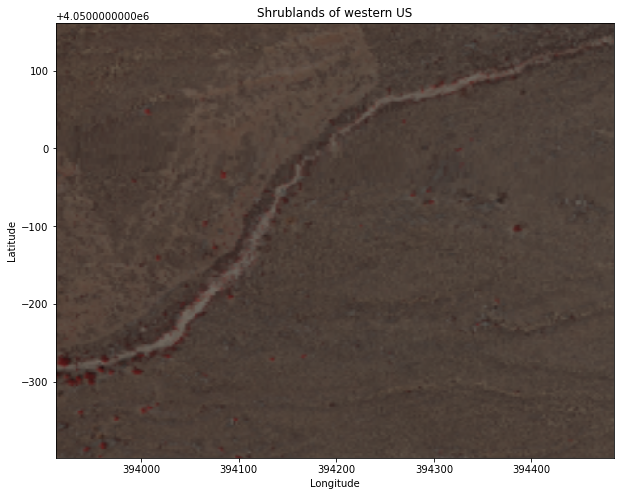

In [6]:
plt.close()
fig, ax = plt.subplots(figsize=(10, 8), facecolor='w', edgecolor='k')
hyper_img.isel(band=[104,62,42]).plot.imshow(ax=ax)
ax.set_title("Shrublands of western US")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.savefig("../reports/figures/CIR_image.png")



## 3. Cleaning the training data (csv file):
1. Remove observations with nan values (no nitrogen measured).
2. Remove the columns with negative reflectance.
3. Remove water absorption bands.    

In [7]:
# Clean CSV file
X, y, non_negative_columns, water_bands, wl = build_features.clean_data(csv_data)
cleaned_csv =np.c_[y, X]
cols = [str(wl[i]) for i in range(len(wl))]
cols.insert(0,"Nitrogen[%]")
cleaned_csv_pd = pd.DataFrame(cleaned_csv,index=None, columns=cols)
cleaned_csv_pd.to_csv("../data/processed/cleaned_csv.csv",index=False)

\
plot the spectra in the training set to have a visual of how data looks like and if there is any significant irregularity.

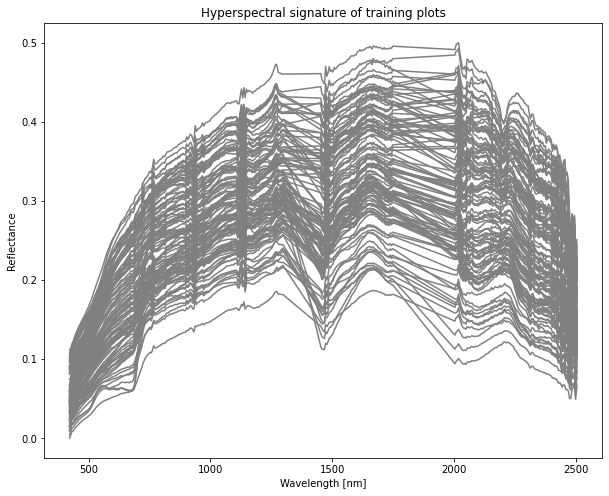

In [8]:
plt.close()
fig, ax = plt.subplots(figsize=(10, 8), facecolor='w', edgecolor='k')
plt.plot(wl,X.T,color="gray")
ax.set_title("Hyperspectral signature of training plots")
ax.set_xlabel("Wavelength [nm]")
ax.set_ylabel("Reflectance")
plt.savefig("../reports/figures/spectral_bands.png")


\
You might notice that some of the hyperspectral signatures does not have the typical 
shape of a vegetation spectra. The main reason is the region is in drylands, so 
canopies carry less leaf area and also their distribution is sparse which both leads
to more contribution of soil to the canopy spectra. 

## 4. Train the plsr model usign two different feature selections techniques
Our goal is to optimize for both model complexity (number of components) and optimal features. 

* The first technique is based on Variable Importance Projection (VIP). The procedure is as follow: 

    - Fit a model with all features for each model with 1 component.
    - Calculate the VIP values for the fitted model.
    - Select features with VIP values greater than 1.
    - Fit the model with selected features and calculate/save error (MSE).
    - Increased the number of component by 1 (up to 15) and repeat the procedure.

We call the model based on this vip_model. 


* The second technique is based on removing the spectral bands that have small
coeeficient after fitting the regression. The procedure is as follow:
    
    - Fit a model with all features for each model with 1 component and estimate
    coeficients.
    - Sort bands based on estimated coeficients in ascending order.
    - Remove bands with smallest coefficients.
    - Fit the model with the remaining bands and calucluate/save the error. 
    - Repeat this procedure for all bands and components. 
    - Find the number of components and sets of bands that leads to the smallest
    error. 

We call this model the vs_model. 


In [9]:
# Fit the vpn plsr model using the module developed
vip_model = hyper_plsr()
vip_model.plsr_vip(X = X, y = y, max_comp=15)

# Fit the variable selection method (It may take a few minutes)
vs_model = hyper_plsr()
vs_model.plsr_vs(X=X, y=y,max_comp= 15)



### Save the model
The model is saved as pickle object to the disk that can be reloaded and used later. 

In [10]:
# Save the models as pickle object to disk
pickle.dump(vip_model.model, open("../models/vip_model.pkl", 'wb'))
pickle.dump(vs_model.model, open("../models/vs_model.pkl", 'wb'))

# To reload the model uncomment the following line:
# vip_model = pickle.load(open(../models/vip_model.pkl, 'rb'))
# vs_model = pickle.load(open(../models/vip_model.pkl, 'rb'))

\
Plot the selected bands using both methods.

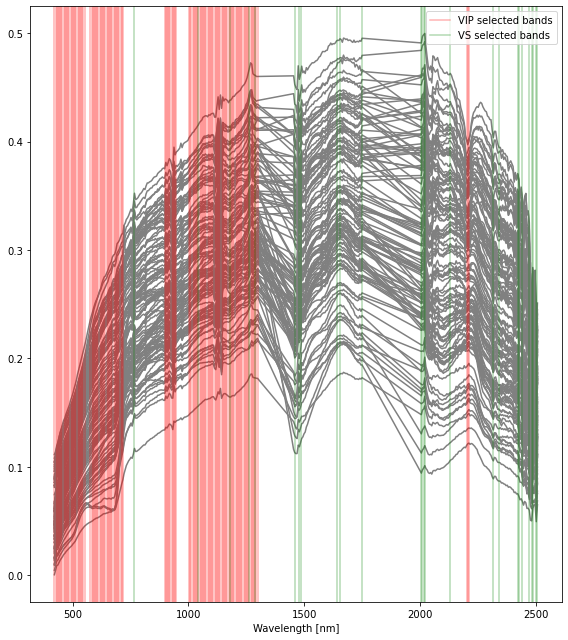

In [11]:
# Ploting the selected bands
plt.close()
fig, ax = plt.subplots(figsize=(8, 9))
ax.plot(wl, X.T, color="gray")
selected_wl_vip = wl[vip_model.selected_index]

[
    plt.axvline(
        x=selected_wl_vip[i], color="red", alpha=0.3, label="VIP selected bands"
    )
    for i in range(len(selected_wl_vip))
]

selected_wl_vs = wl[vs_model.selected_index]
[
    plt.axvline(
        x=selected_wl_vs[i], color="green", alpha=0.3, label="VS selected bands"
    )
    for i in range(len(selected_wl_vs))
]
handles, labels = plt.gca().get_legend_handles_labels()
temp = {k: v for k, v in zip(labels, handles)}
ax.set_xlabel("Wavelength [nm]")
plt.legend(temp.values(), temp.keys(), loc="best")
plt.tight_layout()
plt.savefig("../reports/figures/selected_bands.png")

As you can see the selected bands are different between the two approach.
Spectral bands selected using the VIP method are mostly in the visible and 
near-infrared parts of the spectrum. However, variables selected in vs_model are mostly in mid-infrared and few near-infrared. Moreover, the number of bands selected is less than the VIP method. 

Now let us take a look at the performance of PLSR based on these variable selections:


In [12]:
print(
    (
        
        f"VIP model calibration R2 and MSE:{np.round(vip_model.scores[0],2)},"
        f" {np.round(vip_model.scores[2],2)}"
        f"\nVIP model cross calibration R2 and MSE:{np.round(vip_model.scores[1],2)},"
        f" {np.round(vip_model.scores[3],2)}\n"
        f"VS model calibration R2 and MSE:{np.round(vs_model.scores[0],2)},"
        f" {np.round(vs_model.scores[2],2)}"
        f"\nVS model cross calibration R2 and MSE:{np.round(vs_model.scores[1],2)},"
        f" {np.round(vs_model.scores[3],2)}"
    )
)

VIP model calibration R2 and MSE:0.54, 0.07
VIP model cross calibration R2 and MSE:0.33, 0.11
VS model calibration R2 and MSE:0.76, 0.04
VS model cross calibration R2 and MSE:0.51, 0.08


As you can see, vs_model led to slightly better calibration and cross validation R2 and Minimum Square Error (MSE). Thus, for this project, we choose the vs-model as our 
the predictive model to estimate and map nitrogen content from the hyperspectral image.


## 5. Apply vs_model to the hyperspectral image

To apply the model to the image we need to prepare the image and make
it consistent with the model. In another word: 

- Remove the bad bands (negative reflectance and water absorption bands)
indicated in step1. 
- Select those bands that we identify as important during model training in step 4.

In [13]:
# Remove bad bands
img = hyper_img.isel(band=non_negative_columns)
img = img.drop(water_bands, dim="band")

# Select important bands
img_sorted = img.isel(band=vs_model.selected_index)
print(img_sorted)

<xarray.DataArray (band: 26, y: 559, x: 572)>
[8313448 values with dtype=float32]
Coordinates:
  * band         (band) int64 237 339 275 234 271 132 ... 359 372 371 367 368
  * x            (x) float64 3.939e+05 3.939e+05 ... 3.945e+05 3.945e+05
  * y            (y) float64 4.05e+06 4.05e+06 4.05e+06 ... 4.05e+06 4.05e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0


### Apply model to the image

In [14]:
nitrogen_map = hyper_plsr.xr_predict(img_sorted, vs_model.model, "band")

### Plot the nitrogen map

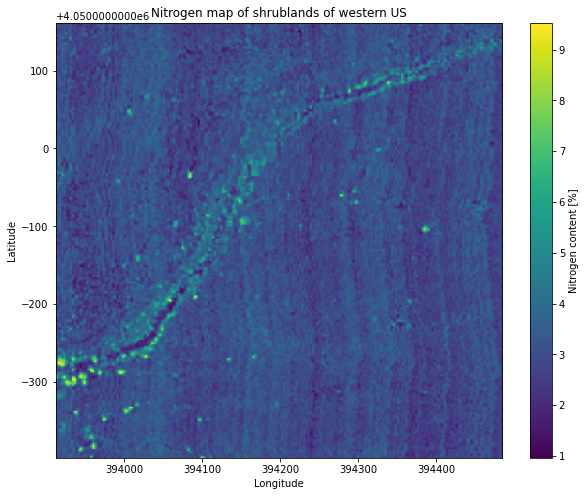

In [15]:
plt.close()
fig, ax = plt.subplots(figsize=(10, 8), facecolor='w', edgecolor='k')
nitrogen_map.plot.imshow(cbar_kwargs={'label':"Nitrogen content [%]"})
ax.set_title("Nitrogen map of shrublands of western US")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.savefig("../reports/figures/nitrogen_map.png")

Concluding remarks
-------------

* Please note this code is just a sample code and it does not intend to perform exhaustive research. In one of my manuscripts [(Here)](https://ieeexplore.ieee.org/document/8633855), we performed a complete analysis of different machine learning techniques in estimating nitrogen using hyperspectral data and we showed some of the challenges associated with these methods in drylands. Some example approaches to improve the predictive model are:

    * Using different feature selection techniques. There are multiple different ways to do variable selections using PLSR [(Here)](https://www.sciencedirect.com/science/article/pii/S0169743912001542). 

    * Spectral transformation such as log, derivatives, and smoothing.
    * Using other machine learning methods such as Random Forest. 


* Finally, in the application of machine learning we should consider the interpretability of the fitted model as well. For example, it is a good idea to check if the selected bands used in the predictive model used in this study have any correspondence with the physical interaction between light and nitrogen within the canopy (i.e. nitrogen absorption features). 
